In [45]:
import re

import numpy as np
import pandas as pd
import torch
import plotly.express as px
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
)



In [46]:
# Load the local dataset

df = pd.read_csv("../data/phishing_site_urls.csv")
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [47]:
# Preprocessing 1 -- duplicate and NaN processsing
df['Label'] = df['Label'].map({'good': 0, 'bad': 1})

df.dropna(inplace=True,axis=0)      # removes any row that contain missing values nan
df.drop_duplicates(inplace=True)    # removes duplicate row from the dataframe

df.head()


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


In [ ]:
# optional, sample the datset to speed up training

import pandas as pd

# assume df has a column 'Label' with 0 and 1
n = 2500
df = pd.concat([
    df[df.Label == 0].sample(n, random_state=42),
    df[df.Label == 1].sample(n, random_state=42),
]).sample(frac=1, random_state=42).reset_index(drop=True)

df.count()

URL      100
Label    100
dtype: int64

In [49]:
# Preprocessing 2 -- clean urls

def clean_url(url):
    # Remove protocols
    url = re.sub(r'https?://', '', url)
    url = re.sub(r'www\.', '', url)

    # Lowercase
    url = url.lower()

    # Remove trailing slashes
    url = url.rstrip('/')

    # Optional: remove special characters except dots, slashes, and dashes
    url = re.sub(r'[^a-zA-Z0-9./\-]', '', url)
   
    return url

# Apply cleaning
df['URL'] = df['URL'].apply(clean_url)

# Preview cleaned data
print(df.head())

                                                 URL  Label
0  verifierbyviseurverifierbyviseur.com/verifier/...      1
1  annakraktour.pl/world/gucci2014/gdocs/processi...      1
2  9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...      1
3                                       seattleu.edu      0
4  ghanavillage.com/showthread.php/7224-r-amp-b-s...      0


In [50]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)


In [51]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["URL"],
                     truncation=True,
                     padding="max_length",
                     max_length=128)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test":  Dataset.from_pandas(test_df),
})

ds = ds.rename_column("Label", "labels")

ds = ds.map(tokenize, batched=True)
ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 20/20 [00:00<00:00, 9087.43 examples/s]


In [52]:
import torch

print("MPS available:", torch.backends.mps.is_available())   # True if MPS is usable
print("MPS built-in:", torch.backends.mps.is_built())        # True if MPS was compiled in

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)


MPS available: True
MPS built-in: True
Using device: mps


In [ ]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}

model_name = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

args = TrainingArguments(
    output_dir=f"./{model_name.replace('/', '_')}-out",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    use_mps_device=True,
)

# 4. Trainer & run
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
print("Final results:", trainer.evaluate())


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/briansterle/Library/Mobile Documents/com~apple~CloudDocs/compsci-masters/spring25/579_CyberThreatsAndDefense/final_project/.venv/lib/python3.12/site-packages/transformers/training_args.py:2243: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
/var/folders/k9/gqghktb1187d9tphx4_lfjxc0000gn/T/ipykernel_6110/4253724080.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `proces

Step,Training Loss


/Users/briansterle/Library/Mobile Documents/com~apple~CloudDocs/compsci-masters/spring25/579_CyberThreatsAndDefense/final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Final results: {'eval_loss': 0.6612265706062317, 'eval_accuracy': 0.65, 'eval_runtime': 0.4476, 'eval_samples_per_second': 44.682, 'eval_steps_per_second': 2.234, 'epoch': 1.0}


accuracy from transformer: 65.00 %
f1 score from transformer: 46.15 %
classification report:
               precision    recall  f1-score   support

           0       0.59      1.00      0.74        10
           1       1.00      0.30      0.46        10

    accuracy                           0.65        20
   macro avg       0.79      0.65      0.60        20
weighted avg       0.79      0.65      0.60        20



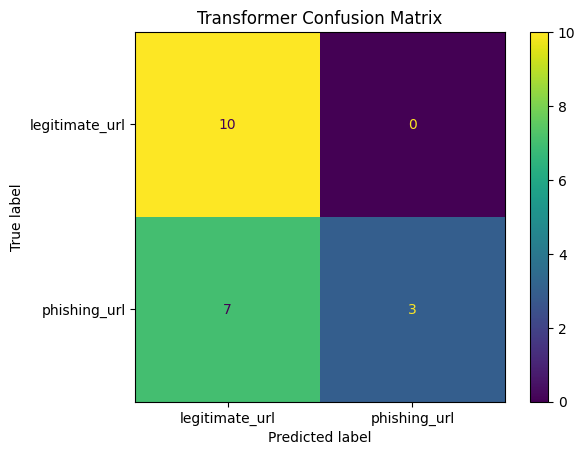

In [54]:
# Evaluate transformer model and plot confusion matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

pred_out = trainer.predict(ds["test"])
preds = np.argmax(pred_out.predictions, axis=1)
labels = pred_out.label_ids

print(f"accuracy from transformer: {accuracy_score(labels, preds) * 100:.2f} %")
print(f"f1 score from transformer: {f1_score(labels, preds) * 100:.2f} %")
print("classification report:\n", classification_report(labels, preds))

cm = confusion_matrix(labels, preds, labels=[0, 1])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["legitimate_url", "phishing_url"]).plot()
plt.title("Transformer Confusion Matrix")
plt.show()
